# 4 Autonomous Research Agents — LangGraph Agentic Graph

**Architecture:** A single LangGraph executor node routes dynamically at runtime.  
The flow is **never hard-coded** — each agent decides `next_agent` in its output.

| Agent | Role |
|-------|------|
| **Planner** | Understands goal, breaks into sub-questions, decides who runs next |
| **Researcher** | RAG retrieval from vector DB, grounded answers + sources |
| **Evaluator** | Scores confidence, detects gaps, routes to Expansion or END |
| **Expansion** | ArXiv search (online mode) **or** idea generation only (workspace mode) |

---

## Two Operating Modes

| Mode | `search_mode` value | Expansion behaviour |
|------|--------------------|--------------------|
| **Online** | `"online"` | Searches ArXiv, downloads & indexes new papers, loops back to Researcher |
| **Workspace-only** | `"workspace"` | Never touches the internet — uses only local PDFs already indexed |

Set `SEARCH_MODE` in **Section 11** before running.

---

```
  ┌─────────────────────────────────────────┐
  │          LangGraph StateGraph           │
  │                                         │
  │   ┌──────────────────────────────┐      │
  │   │       agent_executor         │◄─┐   │
  │   │  (single dynamic dispatcher) │  │   │
  │   └──────────┬───────────────────┘  │   │
  │              │                      │   │
  │         route(state)                │   │
  │         /         \                 │   │
  │      LOOP          END              │   │
  │        └───────────┘────────────────┘   │
  └─────────────────────────────────────────┘

  AGENT_REGISTRY maps name → function at runtime:
    'Planner'    → planner_agent(state)
    'Researcher' → researcher_agent(state)
    'Evaluator'  → evaluator_agent(state)
    'Expansion'  → expansion_agent(state)   ← behaviour controlled by search_mode
```

## 0. Install Dependencies

In [8]:
# !pip install -q langgraph langchain langchain-core langchain-community langchain-groq \
#               langchain-openai langchain-chroma chromadb openai \
#               pypdf arxiv python-dotenv

## 1. Imports & Environment

In [1]:
import os
import json
import hashlib
from pathlib import Path
from typing import Any, Callable, TypedDict

import arxiv
from dotenv import load_dotenv

from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

load_dotenv()

# ── LLM (Groq — swap for any LangChain ChatModel) ──────────────────────────
llm = None
try:
    from langchain_groq import ChatGroq
    _key = os.getenv("GROQ_API_KEY", "")
    if _key:
        llm = ChatGroq(
            model=os.getenv("GROQ_MODEL", "llama-3.3-70b-versatile"),
            temperature=0.1,
            api_key=_key,
        )
        print("✅ LLM ready:", llm.model_name)
    else:
        print("⚠️  GROQ_API_KEY not set — agents will use fallback logic")
except ImportError:
    print("⚠️  langchain-groq not installed — agents will use fallback logic")

# ── Workspace directories ───────────────────────────────────────────────────
WORK_DIR   = Path("./agent_workspace")
PDF_DIR    = WORK_DIR / "papers_local"       # drop your PDFs here
ARXIV_DIR  = WORK_DIR / "papers_arxiv"       # Expansion agent saves here
CHROMA_DIR = WORK_DIR / "chroma_db"

for d in [WORK_DIR, PDF_DIR, ARXIV_DIR, CHROMA_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print("📁 Workspace:", WORK_DIR.resolve())

/home/codespace/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ LLM ready: llama-3.3-70b-versatile
📁 Workspace: /workspaces/research-hub/agent_workspace


## 2. Shared Helpers

In [2]:
# ── JSON parsing ────────────────────────────────────────────────────────────
def _parse_json(text: str) -> dict:
    t = text.strip()
    if t.startswith("```"):
        t = t.replace("```json", "").replace("```", "").strip()
    return json.loads(t)


def _llm_json(prompt: str, fallback: dict) -> dict:
    """Call the LLM and parse JSON output. Return fallback on any error."""
    if llm is None:
        return fallback
    try:
        raw = llm.invoke([HumanMessage(content=prompt)]).content
        return _parse_json(raw)
    except Exception as e:
        print(f"  [LLM parse error] {e}")
        return fallback


# ── Vector DB (Chroma + OpenAI embeddings) ─────────────────────────────
def build_vectordb():
    """Instantiate (or reuse) the persistent Chroma vector store."""
    from langchain_openai import OpenAIEmbeddings
    try:
        from langchain_chroma import Chroma
    except ImportError:
        from langchain_community.vectorstores import Chroma  # type: ignore

    emb = OpenAIEmbeddings(model=os.getenv("OPENAI_EMBED_MODEL", "text-embedding-3-small"))
    vdb = Chroma(
        collection_name="autonomous_4agents",
        embedding_function=emb,
        persist_directory=str(CHROMA_DIR),
    )
    return vdb


def ingest_dirs(vdb, dirs: list[Path]) -> int:
    """Load all PDFs from dirs, chunk them, and upsert into the vector store."""
    pdfs = [p for d in dirs for p in d.rglob("*.pdf")]
    docs: list[Document] = []
    for p in pdfs:
        try:
            pages = PyPDFLoader(str(p)).load()
            for pg in pages:
                pg.metadata["source"] = str(p)
            docs.extend(pages)
        except Exception:
            pass
    if not docs:
        return 0
    splitter = RecursiveCharacterTextSplitter(chunk_size=1_200, chunk_overlap=200)
    chunks = splitter.split_documents(docs)
    ids = [
        hashlib.md5(
            f"{c.metadata.get('source')}|{c.metadata.get('page',-1)}|{c.page_content[:80]}"
            .encode()
        ).hexdigest()
        for c in chunks
    ]
    if chunks:
        vdb.add_documents(chunks, ids=ids)
    return len(chunks)


def retrieve(vdb, query: str, k: int = 8) -> list[Document]:
    return vdb.similarity_search(query, k=k)


# ── ArXiv helper ─────────────────────────────────────────────────────────────
def arxiv_expand(query: str, max_results: int = 4) -> list[Path]:
    """Search ArXiv, download PDFs, return file paths."""
    client = arxiv.Client(page_size=max_results, delay_seconds=3, num_retries=3)
    search = arxiv.Search(
        query=query, max_results=max_results,
        sort_by=arxiv.SortCriterion.Relevance,
    )
    saved = []
    for r in client.results(search):
        try:
            fp = r.download_pdf(dirpath=str(ARXIV_DIR), filename=f"{r.get_short_id()}.pdf")
            saved.append(Path(fp))
        except Exception:
            pass
    return saved


print("✅ Helpers ready")

✅ Helpers ready


## 3. State Schema

One `TypedDict` carries everything through the graph.  
`current_agent` tells the executor **which** agent to run next.

In [3]:
class AgentState(TypedDict, total=False):
    # ── Core ──────────────────────────────────────────────────────────────
    goal: str                   # research question
    vdb: Any                    # Chroma vector store (passed by reference)
    current_agent: str          # which agent is active RIGHT NOW
    next_agent: str             # where to route after this agent
    iterations: int             # expansion loop counter
    max_iterations: int         # hard cap on expansion loops

    # ── Mode ──────────────────────────────────────────────────────────────
    search_mode: str            # "online"  → ArXiv search allowed
                                # "workspace" → use only local/already-indexed PDFs

    # ── Per-agent outputs (accumulated in state) ─────────────────────────
    planner:    dict            # {subtasks, next_agent}
    researcher: dict            # {answer, sources, next_agent}
    evaluator:  dict            # {confidence, missing_aspects, next_agent}
    expansion:  dict            # {query, papers_downloaded, chunks_added, saturated, ideas, mode}

    # ── Final outputs ────────────────────────────────────────────────────
    final_answer: str
    final_sources: list
    future_ideas: list
    trace: list                 # execution log ["Planner → Researcher", ...]

    # ── Insufficiency tracking ────────────────────────────────────────────
    insufficient_data: bool     # True when the system could not gather enough evidence
    insufficiency_reason: str   # human-readable explanation of why data was insufficient

## 4. Agent 1 — Planner (Lightweight Brain)

- Understands the research goal  
- Breaks it into sub-questions  
- Decides who runs next (always `Researcher`)  
- **Does NOT search** — pure reasoning only

In [4]:
def planner_agent(state: AgentState) -> dict:
    goal = state["goal"]
    print(f"  🧠 [Planner] Goal: {goal[:80]}...")

    fallback = {
        "subtasks": ["model architecture", "training datasets", "evaluation benchmarks"],
        "next_agent": "Researcher",
    }
    prompt = f"""You are the Planner Agent.
Research goal: {goal}

Your job:
1. Understand the goal deeply.
2. Break it into 3-5 focused sub-questions.
3. Do NOT search — only plan.
4. Always route next to Researcher.

Return ONLY valid JSON:
{{"subtasks": ["sub-question 1", "sub-question 2", "..."], "next_agent": "Researcher"}}"""

    out = _llm_json(prompt, fallback)
    subtasks = out.get("subtasks", fallback["subtasks"])
    if not isinstance(subtasks, list):
        subtasks = fallback["subtasks"]

    print(f"  🧠 [Planner] Subtasks: {subtasks}")
    return {
        "planner": {"subtasks": subtasks, "next_agent": "Researcher"},
        "next_agent": "Researcher",
    }

In [122]:
AgentState = {
    "goal":           """✔ Late disease detection
✔ Diagnostic human errors
✔ Slow medical data analysis
✔ Limited healthcare accessibility""",
    "vdb":            vdb,
    "search_mode":    "workspace",
    "current_agent":  "Planner",
    "next_agent":     "Planner",
    "iterations":     0,
    "max_iterations": 3,
    "future_ideas":   [],
    "trace":          [],
}
planner_agent(AgentState)

{'planner': {'subtasks': ['Systematic literature review on late disease detection factors and diagnostic errors.',
   'Characterize diagnostic errors by modality and error type (missed, delayed, cognitive bias).',
   'Assemble and anonymize a multi-institution dataset capturing time-to-diagnosis, misdiagnoses, and outcomes.',
   'Develop and validate AI-assisted screening and triage models to flag potential diseases earlier.',
   'Design clinician decision-support tools to standardize workflows and reduce cognitive bias.',
   'Build a scalable data analysis pipeline for EMR, imaging, and lab data to accelerate insights.',
   'Implement data interoperability with FHIR/HL7 and standard ontologies to speed data sharing.',
   'Prototype telemedicine and mobile health interventions to expand access in underserved areas.',
   'Pilot interventions in rural/low-resource settings to measure impact on time-to-diagnosis and error rates.',
   'Create privacy-preserving analytics (federated learnin

## 5. Agent 2 — Researcher (RAG Agent)

- Retrieves evidence from the Chroma vector DB  
- Generates a grounded answer with source citations  
- Routes to `Evaluator`

In [130]:
from langchain_core.prompts import ChatPromptTemplate

# Simple grounded RAG prompt
researcher_prompt = ChatPromptTemplate.from_template(
#     """You are a Researcher Agent.

# Goal:
# {goal}

# Subtasks:
# {subtasks}

# Use ONLY the provided context to evaluate feasibility.

# <context>
# {context}
# </context>

# Instructions:
# - Determine whether the stated research goal can realistically be solved using the data, methods, experiments, or resources described in the context.
# - Evaluate if the provided methodology, data quality, scope, and approach are sufficient to achieve the goal.
# - If the goal appears achievable based on the context, clearly state that the research is feasible and explain why.
# - If the goal cannot be fully achieved, identify the specific limitations, missing components, unrealistic assumptions, or methodological gaps.
# - You may reason about logical consistency and practical feasibility based strictly on the given context.
# - Do NOT use external knowledge.
# - Do NOT assume information not present in the context.

# If the context does not contain enough information to determine feasibility,
# respond with: "Insufficient information to assess feasibility."

# Answer:
# """
"""You are a Researcher Agent.

Goal:
{goal}

Subtasks:
{subtasks}

Use ONLY the provided context.

<context>
{context}
</context>

Instructions:

- Determine whether the research goal can realistically be solved using the data, methodology, analysis, or approach described in the context.
- Evaluate feasibility, logical consistency, and completeness of the approach.
- If results or evidence are provided, base your conclusion strictly on that evidence.
- If no explicit results are provided, reason based on whether the described methods and data are sufficient to achieve the stated goal.
- If the approach appears sufficient, state that the research goal is achievable and explain why.
- If the approach appears insufficient, clearly identify the gaps (e.g., missing data, weak methodology, unclear evaluation, lack of validation, etc.).
- Do NOT use external knowledge.
- Do NOT assume information not present in the context.

If the context does not contain enough information to assess feasibility,
respond with: "Insufficient information to determine feasibility."

Answer:"""
)


def researcher_agent(state: dict) -> dict:
    goal = state["goal"]
    subtasks = state.get("planner", {}).get("subtasks", [])
    vdb = state["vdb"]

    # Retrieve for main goal + each subtask
    retriever = vdb.as_retriever(search_kwargs={"k": 6})
    docs = []

    docs.extend(retriever.invoke(goal))
    for subtask in subtasks:
        docs.extend(retriever.invoke(subtask))

    # Build context
    context = "\n\n".join(d.page_content for d in docs)
    print(context)
    # Run LLM chain
    chain = researcher_prompt | llm
    result = chain.invoke({
        "goal": goal,
        "subtasks": subtasks,
        "context": context
    })

    answer = result.content 

    sources = [
        {
            "source": d.metadata.get("source"),
            "page": d.metadata.get("page")
        }
        for d in docs
    ]

    # Return both legacy and final keys for compatibility across notebook cells
    return {
        "researcher": {
            "answer": answer,
            "sources": sources,
            "next_agent": "Evaluator",
        },
        "final_answer": answer,
        "final_sources": sources,
        "next_agent": "Evaluator"
    }


In [131]:
state = {"goal":           """✔ Late disease detection
✔ Diagnostic human errors
✔ Slow medical data analysis
✔ Limited healthcare accessibility""",
    "vdb":            vdb,
    "search_mode":    "workspace",
    "current_agent":  "Planner",
    "next_agent":     "Planner",
    "iterations":     0,
    "max_iterations": 3,
    "future_ideas":   [],
    "trace":          [],'planner': {'subtasks': ['Systematic literature review on late disease detection factors and diagnostic errors.',
   'Characterize diagnostic errors by modality and error type (missed, delayed, cognitive bias).',
   'Assemble and anonymize a multi-institution dataset capturing time-to-diagnosis, misdiagnoses, and outcomes.',
   'Develop and validate AI-assisted screening and triage models to flag potential diseases earlier.',
   'Design clinician decision-support tools to standardize workflows and reduce cognitive bias.',
   'Build a scalable data analysis pipeline for EMR, imaging, and lab data to accelerate insights.',
   'Implement data interoperability with FHIR/HL7 and standard ontologies to speed data sharing.',
   'Prototype telemedicine and mobile health interventions to expand access in underserved areas.',
   'Pilot interventions in rural/low-resource settings to measure impact on time-to-diagnosis and error rates.',
   'Create privacy-preserving analytics (federated learning, differential privacy) to enable rapid analysis.',
   'Develop real-time dashboards and alert systems to monitor diagnostic timeliness and data throughput.',
   'Develop risk stratification models to identify patients at high risk for late diagnosis.',
   'Assess regulatory, ethical, and equity implications and formulate actionable recommendations.'],
  'next_agent': 'Researcher'},
 'next_agent': 'Researcher'}

In [132]:
researcher_agent(state)

Using Artificial Intelligence to Improve Early
Disease Detection
Abstract: Early detection of diseases such as cancer and diabetes significantly improves patient
survival rates. Traditional diagnostic systems often rely on manual analysis, which can be slow and
prone to human error. This research explores how Artificial Intelligence (AI) can assist in early
disease detection using machine learning models.
Introduction: Healthcare systems generate large volumes of medical data daily. Analyzing this data
manually is challenging and time-consuming. AI systems can process complex datasets efficiently
and identify patterns that may not be visible to human experts.
Problem Statement: Many diseases are detected at later stages due to slow diagnostic procedures,
human error, and limited access to medical specialists. Late diagnosis increases treatment costs
and reduces survival probability.
Objective: The objective of this research is to develop an AI-based predictive system that improves
earl

{'researcher': {'answer': 'Achievable.\n\nWhy this is feasible based on the provided context:\n- Data modalities and modeling approach exist\n  - The context demonstrates building AI/ML models from structured EHR data augmented with patient-reported outcomes, with data cleaning, encoding, and normalization steps, and evaluation using accuracy, recall, AUROC, and calibration metrics.\n  - Time-to-diagnosis can be framed as a time-to-event endpoint and modeled with approaches mentioned (better targets and calibration, time-to-event modeling, decision-curve/net-benefit analysis).\n  - Multimodal data (EMR, imaging, labs) are acknowledged as targets; the framework supports integrating heterogeneous signals via ensemble/triangulated modeling and parallel learners.\n- Large-scale, multi-institution data handling is addressed\n  - The context explicitly discusses data growth, harmonization, and standard definitions, with federated learning for privacy-preserving training, and external/tempora

## 6. Agent 3 — Evaluator (Critic + Analyzer)

- Judges whether the answer is sufficient  
- Scores confidence (0–1)  
- Detects missing aspects  
- **Online mode:** routes to `END` if confidence ≥ 0.75 **and** ≥ 4 sources, else `Expansion`  
- **Workspace mode:** routes to `END` once the vector DB has been exhausted (no new chunks possible), accepting a lower confidence threshold (≥ 0.50)

In [7]:
# ── Evaluator prompt template ──────────────────────────────────────────────
_evaluator_prompt = ChatPromptTemplate.from_template(
    """You are the Evaluator Agent.

Research goal: {goal}
Operating mode: {mode}

Evaluate the following answer against the goal:
<context>
Answer: {answer}
Number of sources: {num_sources}
</context>

Tasks:
1. Score confidence from 0.0 to 1.0 (how well the answer covers the goal).
2. List specific missing aspects (if any).
3. Routing rule — {mode_instruction}

Return ONLY valid JSON (no markdown, no explanation):
{{"confidence": 0.62, "missing_aspects": ["...", "..."], "next_agent": "Expansion"}}"""
)


def evaluator_agent(state: AgentState) -> dict:
    goal        = state["goal"]
    researcher   = state.get("researcher", {}) if isinstance(state.get("researcher", {}), dict) else {}
    answer       = researcher.get("answer", state.get("final_answer", ""))
    sources      = researcher.get("sources", state.get("final_sources", []))
    mode         = state.get("search_mode", "workspace")
    print(f"  🧪 [Evaluator] Mode={mode} | Judging answer ({len(sources)} sources)...")

    fallback = {
        "confidence": 0.55 if len(sources) >= 3 else 0.30,
        "missing_aspects": ["experimental validation", "ablation studies"],
        "next_agent": "Expansion",
    }

    mode_instruction = (
        "Set next_agent to END only if answer quality is strong and coverage is high. "
        "If the answer is incomplete, vague, or weakly evidenced, set next_agent to Expansion."
        if mode == "online"
        else
        "Workspace-only mode: be moderately lenient, but still avoid END if answer is vague/off-topic/unsupported. "
        "Set next_agent to Expansion when quality is poor so ideas can still be generated."
    )

    # ── LCEL evaluation chain: prompt | llm ──────────────────────────────
    # Mirrors the document_chain pattern from 1.1.2-Simpleapp
    out = fallback
    if llm is not None:
        try:
            eval_chain = _evaluator_prompt | llm
            result = eval_chain.invoke({
                "goal":             goal,
                "mode":             mode,
                "answer":           answer[:1500],
                "num_sources":      len(sources),
                "mode_instruction": mode_instruction,
            })
            raw = result.content.strip() if hasattr(result, "content") else str(result).strip()
            # Strip markdown fences if present
            if raw.startswith("```"):
                raw = raw.replace("```json", "").replace("```", "").strip()
            parsed = json.loads(raw)
            out = parsed
        except Exception as e:
            print(f"  🧪 [Evaluator] LLM chain error: {e}")

    confidence      = float(out.get("confidence", fallback["confidence"]))
    missing_aspects = out.get("missing_aspects", fallback["missing_aspects"])
    if not isinstance(missing_aspects, list):
        missing_aspects = fallback["missing_aspects"]

    # ── Deterministic quality checks (prevent false "goal achieved" routing) ──
    answer_clean   = answer.strip()
    answer_len_ok  = len(answer_clean) >= 220
    unique_sources = len({s.get("source", "") for s in sources if isinstance(s, dict)})

    stopwords = {
        "what", "which", "with", "from", "into", "that", "this", "those", "these",
        "their", "there", "about", "have", "been", "being", "were", "when", "where",
        "how", "can", "for", "and", "the", "are", "key", "overcome", "using", "than",
    }
    goal_terms = [
        w for w in ''.join(ch.lower() if ch.isalnum() else ' ' for ch in goal).split()
        if len(w) >= 5 and w not in stopwords
    ]
    if goal_terms:
        matches      = sum(1 for t in goal_terms if t in answer_clean.lower())
        goal_coverage = matches / len(goal_terms)
    else:
        goal_coverage = 0.0

    # Cap overly optimistic model confidence if grounding is weak
    if not answer_clean or len(sources) == 0:
        confidence = min(confidence, 0.30)
    elif goal_coverage < 0.25 or unique_sources < 1:
        confidence = min(confidence, 0.55)
    elif unique_sources < 2:
        confidence = min(confidence, 0.70)

    if mode == "workspace":
        sufficient = (
            answer_len_ok
            and len(sources) >= 1
            and goal_coverage >= 0.30
            and confidence >= 0.45
        )
    else:
        sufficient = (
            answer_len_ok
            and len(sources) >= 3
            and unique_sources >= 2
            and goal_coverage >= 0.40
            and confidence >= 0.72
        )

    next_agent = "END" if sufficient else "Expansion"

    print(
        "  🧪 [Evaluator] "
        f"Confidence={confidence:.2f} | Coverage={goal_coverage:.2f} | "
        f"UniqueSources={unique_sources} | Sufficient={sufficient} | Next={next_agent}"
    )
    return {
        "evaluator": {
            "confidence":      confidence,
            "missing_aspects": missing_aspects,
            "next_agent":      next_agent,
        },
        "next_agent": next_agent,
    }

## 7. Agent 4 — Expansion (Explorer + Innovator)

**Online mode (`search_mode = "online"`):**
- Searches ArXiv for papers covering missing aspects  
- Ingests new PDFs into the vector DB  
- If new papers found → loops back to `Researcher`  
- If saturated (no new papers **or** max iterations reached) → generates ideas → `END`

**Workspace-only mode (`search_mode = "workspace"`):**
- Skips all internet access  
- Goes straight to generating novel research ideas from missing aspects  
- Always routes to `END` (no new retrieval is possible)

In [8]:
def expansion_agent(state: AgentState) -> dict:
    goal           = state["goal"]
    vdb            = state["vdb"]
    missing        = state.get("evaluator", {}).get("missing_aspects", [])
    iterations     = int(state.get("iterations", 0)) + 1
    max_iterations = int(state.get("max_iterations", 4))
    mode           = state.get("search_mode", "online")
    # Was the last Researcher call a total blank?
    prev_answer    = state.get("final_answer", "")
    prev_sources   = state.get("final_sources", [])

    print(f"  🚀 [Expansion] Mode={mode} | Iteration {iterations}/{max_iterations}")
    print(f"  🚀 [Expansion] Missing aspects: {missing}")

    # ── Shared: generate novel research ideas ─────────────────────────────
    def _generate_ideas(reason: str) -> list[str]:
        print(f"  🚀 [Expansion] Generating ideas ({reason})...")
        fallback_ideas = {
            "ideas": [
                "Design targeted experiments to address missing aspects.",
                "Create stronger benchmarks with edge-case coverage.",
                "Run ablation studies to isolate causal contributors.",
                "Apply iterative human-in-the-loop error analysis.",
                "Explore cross-domain transfer to validate generalisability.",
            ]
        }
        prompt = f"""You are the Expansion Agent.
Research goal: {goal}
Missing aspects: {missing}
Reason for idea generation: {reason}

Generate 4-6 concrete, novel research ideas or future directions
that could address the missing aspects.

Return ONLY valid JSON:
{{"ideas": ["idea 1", "idea 2", "..."]}}"""
        out = _llm_json(prompt, fallback_ideas)
        raw = out.get("ideas", fallback_ideas["ideas"])
        return [str(x) for x in raw] if isinstance(raw, list) else fallback_ideas["ideas"]

    # ══════════════════════════════════════════════════════════════════════
    # WORKSPACE-ONLY MODE — no internet, ideas only
    # ══════════════════════════════════════════════════════════════════════
    if mode == "workspace":
        ideas = _generate_ideas("workspace-only mode — no ArXiv access")

        # Detect true insufficiency: DB was empty when Researcher ran
        truly_insufficient = (len(prev_sources) == 0 and prev_answer == "")
        if truly_insufficient:
            insuff_reason = (
                "Workspace mode is active but the vector DB contains no documents. "
                f"Add PDFs to {PDF_DIR.resolve()} and re-run Section 10."
            )
            print(f"  🚀 [Expansion] ⚠️  INSUFFICIENT DATA — {insuff_reason}")
        else:
            insuff_reason = ""

        print(f"  🚀 [Expansion] [WORKSPACE] Generated {len(ideas)} ideas → END")
        out_dict = {
            "iterations": iterations,
            "expansion": {
                "mode":              "workspace",
                "query":             None,
                "papers_downloaded": 0,
                "chunks_added":      0,
                "saturated":         True,
                "ideas":             ideas,
                "next_agent":        "END",
            },
            "future_ideas": ideas,
            "next_agent":   "END",
        }
        if truly_insufficient:
            out_dict["insufficient_data"]     = True
            out_dict["insufficiency_reason"]  = insuff_reason
        return out_dict

    # ══════════════════════════════════════════════════════════════════════
    # ONLINE MODE — ArXiv search + ingest
    # ══════════════════════════════════════════════════════════════════════
    query      = f"{goal} {' '.join(missing[:3])}"
    downloaded = arxiv_expand(query, max_results=4)
    added      = ingest_dirs(vdb, [ARXIV_DIR]) if downloaded else 0
    print(f"  🚀 [Expansion] [ONLINE] Downloaded {len(downloaded)} papers | Indexed {added} chunks")

    saturated  = (added == 0) or (iterations >= max_iterations)
    ideas      = _generate_ideas("ArXiv saturated") if saturated else []
    next_agent = "END" if saturated else "Researcher"

    # Detect true insufficiency: saturated on iteration 1 with no prior answer
    truly_insufficient = (
        saturated
        and iterations == 1
        and len(downloaded) == 0
        and len(prev_sources) == 0
    )
    if truly_insufficient:
        insuff_reason = (
            f"ArXiv returned no papers for the query: '{query}'. "
            "The topic may be too niche, phrased unusually, or ArXiv may be unreachable. "
            "Try rephrasing the research goal, adding local PDFs, or checking your connection."
        )
        print(f"  🚀 [Expansion] ⚠️  INSUFFICIENT DATA — {insuff_reason}")
    else:
        insuff_reason = ""

    print(f"  🚀 [Expansion] [ONLINE] Saturated={saturated} | Next={next_agent}")
    out_dict = {
        "iterations": iterations,
        "expansion": {
            "mode":              "online",
            "query":             query,
            "papers_downloaded": len(downloaded),
            "chunks_added":      added,
            "saturated":         saturated,
            "ideas":             ideas,
            "next_agent":        next_agent,
        },
        "future_ideas": ideas,
        "next_agent":   next_agent,
    }
    if truly_insufficient:
        out_dict["insufficient_data"]    = True
        out_dict["insufficiency_reason"] = insuff_reason
    return out_dict

## 8. Dynamic Registry & Executor

**No hard-coded edges between agents.**  
A single `agent_executor` node reads `state['current_agent']`,  
looks up the function in `AGENT_REGISTRY`, and calls it.

In [9]:
# ── Registry: name → function ────────────────────────────────────────────────
AGENT_REGISTRY: dict[str, Callable[[AgentState], dict]] = {
    "Planner":    planner_agent,
    "Researcher": researcher_agent,
    "Evaluator":  evaluator_agent,
    "Expansion":  expansion_agent,
}


# ── Single dynamic executor node ─────────────────────────────────────────────
def agent_executor(state: AgentState) -> AgentState:
    """
    The ONLY node in the graph.
    Reads current_agent from state, dispatches to the right function,
    then updates state with the result.
    """
    # Resolve agent functions at runtime to avoid stale references when cells are re-run out of order.
    runtime_registry: dict[str, Callable[[AgentState], dict]] = {
        "Planner": planner_agent,
        "Researcher": researcher_agent,
        "Evaluator": evaluator_agent,
        "Expansion": expansion_agent,
    }

    current = state.get("current_agent", "Planner")
    fn      = runtime_registry.get(current)

    if fn is None:
        print(f"  ❌ Unknown agent: {current}")
        return {
            **state,
            "next_agent":    "END",
            "current_agent": "END",
            "trace":         state.get("trace", []) + [f"{current} -> UNKNOWN -> END"],
        }

    # Run the agent
    update     = fn(state)
    next_agent = update.get("next_agent", "END")
    trace      = state.get("trace", []) + [f"{current} → {next_agent}"]

    return {
        **state,
        **update,
        "current_agent": next_agent,
        "trace":         trace,
    }


# ── Conditional routing function ─────────────────────────────────────────────
def route(state: AgentState) -> str:
    """
    After every agent_executor call:
      - next_agent == 'END'  → stop the graph
      - anything else        → loop back to agent_executor
    """
    return "END" if state.get("next_agent", "END") == "END" else "LOOP"


print("✅ Registry:", list(AGENT_REGISTRY.keys()))

✅ Registry: ['Planner', 'Researcher', 'Evaluator', 'Expansion']


## 9. Build the LangGraph

```
  START
    │
    ▼
 agent_executor  ◄──────────────┐
    │                           │
  route(state)                  │
   /      \                     │
 END      LOOP ─────────────────┘
```

Only **one node**, one **conditional edge** — routing is 100% data-driven.

✅ LangGraph compiled


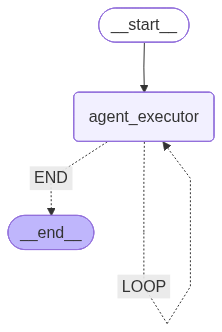

In [10]:
def build_graph():
    g = StateGraph(AgentState)

    # Single executor node
    g.add_node("agent_executor", agent_executor)

    # Entry point
    g.set_entry_point("agent_executor")

    # Dynamic routing — no hard-coded agent-to-agent edges
    g.add_conditional_edges(
        "agent_executor",
        route,
        {
            "LOOP": "agent_executor",   # run next agent in same node
            "END":  END,                # terminate graph
        },
    )

    return g.compile()


graph = build_graph()
print("✅ LangGraph compiled")

# Optional: visualise the graph structure
try:
    from IPython.display import display, Image
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    print("  (graph visualisation requires pygraphviz — skipping)")

## 10. Initialise Vector DB & Ingest Local Papers

In [109]:
print("Building vector DB...")
vdb = build_vectordb()

# Ingest any PDFs already in the workspace
chunks = ingest_dirs(vdb, [PDF_DIR, ARXIV_DIR])
print(f"✅ Vector DB ready | {chunks} chunks indexed from existing PDFs")
print(f"   Drop additional PDFs into: {PDF_DIR.resolve()}")

Building vector DB...
Found 11 PDF(s) for ingestion
  loaded: 2602.17888v1.pdf (48 pages)
  loaded: 2510.25621v1.pdf (37 pages)


EOF marker not found


  failed: 1411.4413v2.pdf: PdfStreamError: Stream has ended unexpectedly
  loaded: 2601.05264v1.pdf (86 pages)
  loaded: 2411.18583v1.pdf (6 pages)
  loaded: 2504.13684v1.pdf (8 pages)
  loaded: 2401.15391v1.pdf (14 pages)
  loaded: 2503.16581v1.pdf (11 pages)
  loaded: 2502.13957v2.pdf (25 pages)
  loaded: 2309.02144v1.pdf (19 pages)
  loaded: 2510.22344v1.pdf (30 pages)
Indexed 892 chunk(s) from 284 page(s)
Collection total chunks: 894
✅ Vector DB ready | 892 chunks indexed from existing PDFs
   Drop additional PDFs into: /workspaces/research-hub/agent_workspace/papers_local


## 11. Run the Autonomous Agent System

**Choose your mode then run the cell below.**

| `SEARCH_MODE` | What happens |
|---------------|-------------|
| `"online"` | Planner → Researcher (local RAG) → Evaluator → **Expansion downloads ArXiv papers** → loops until confident → ideas |
| `"workspace"` | Planner → Researcher (local RAG only) → Evaluator → **Expansion generates ideas from existing knowledge** → END |

> **Tip — workspace mode:** Make sure you have PDFs in `./agent_workspace/papers_local/`  
> and have run **Section 10** so they are indexed before starting.

In [110]:
# ╔══════════════════════════════════════════════════════════════╗
# ║                    CONFIGURE HERE                           ║
# ╠══════════════════════════════════════════════════════════════╣
# ║  SEARCH_MODE                                                ║
# ║    "online"    — search ArXiv for missing papers            ║
# ║    "workspace" — use only locally indexed PDFs              ║
# ╚══════════════════════════════════════════════════════════════╝

SEARCH_MODE    = "workspace"       # ← change to "workspace" for offline mode

RESEARCH_GOAL  = (
    "To accurately predict a protein’s three-dimensional (3D) structure directly from its amino acid sequence using artificial intelligence, eliminating the need for time-consuming and expensive experimental methods."
)

MAX_ITERATIONS = 3              # max Expansion→Researcher loops (online mode only)

# ── Validate mode ─────────────────────────────────────────────────────────
assert SEARCH_MODE in ("online", "workspace"), \
    f"SEARCH_MODE must be 'online' or 'workspace', got: {SEARCH_MODE!r}"

mode_label = {
    "online":    "🌐 ONLINE  — ArXiv search enabled",
    "workspace": "💾 WORKSPACE — local PDFs only, no internet",
}[SEARCH_MODE]

# ── Initial state ──────────────────────────────────────────────────────────
initial_state: AgentState = {
    "goal":           RESEARCH_GOAL,
    "vdb":            vdb,
    "search_mode":    SEARCH_MODE,
    "current_agent":  "Planner",
    "next_agent":     "Planner",
    "iterations":     0,
    "max_iterations": MAX_ITERATIONS,
    "future_ideas":   [],
    "trace":          [],
}

print("=" * 65)
print(f"MODE  : {mode_label}")
print(f"GOAL  : {RESEARCH_GOAL}")
print("=" * 65)

# ── Execute ────────────────────────────────────────────────────────────────
result = graph.invoke(initial_state)

print("\n" + "=" * 65)
print("RUN COMPLETE")
print("=" * 65)

MODE  : 💾 WORKSPACE — local PDFs only, no internet
GOAL  : To accurately predict a protein’s three-dimensional (3D) structure directly from its amino acid sequence using artificial intelligence, eliminating the need for time-consuming and expensive experimental methods.

RUN COMPLETE


## 12. Results

## 12b. Full Autonomous Research Report

In [111]:
# ════════════════════════════════════════════════════════════════════
#  FULL AUTONOMOUS RESEARCH REPORT
#  Displays every stage of the multi-agent run in a readable format.
#  Run this cell after Section 11 (graph.invoke) has completed.
# ════════════════════════════════════════════════════════════════════

SEP  = "═" * 68
SEP2 = "─" * 68

def _section(title: str) -> None:
    print(f"\n{SEP}")
    print(f"  {title}")
    print(SEP)

def _sub(title: str) -> None:
    print(f"\n{title}")
    print(SEP2)

# ── 0. Header ────────────────────────────────────────────────────────
mode       = result.get("search_mode", "workspace")
mode_label = "🌐 ONLINE  — ArXiv search enabled" if mode == "online" else "💾 WORKSPACE — local PDFs only"
_section("AUTONOMOUS RESEARCH REPORT")
print(f"  Mode  : {mode_label}")
print(f"  Goal  : {result.get('goal', 'N/A')}")

# ── 1. Insufficient-data warning (shown prominently if triggered) ────
if result.get("insufficient_data"):
    reason = result.get("insufficiency_reason", "Unknown.")
    print(f"\n{'⚠️  ' * 17}")
    print("  ⚠️  INSUFFICIENT DATA — the system could not gather enough evidence")
    print(f"  Reason : {reason}")
    if mode == "online":
        print("\n  Suggestions:")
        print("    • Rephrase RESEARCH_GOAL with more specific terminology")
        print("    • Add relevant PDFs to ./agent_workspace/papers_local/")
        print("    • Increase max_results in expansion_agent (currently 4)")
        print("    • Check internet connection (ArXiv requires network access)")
    else:
        print("\n  Suggestions:")
        print("    • Add PDFs to ./agent_workspace/papers_local/ and re-run Section 10")
        print("    • Switch SEARCH_MODE = 'online' to let the agent fetch papers")
    print(f"{'⚠️  ' * 17}")

# ── 2. Execution trace ───────────────────────────────────────────────
_sub("📍 EXECUTION TRACE")
trace = result.get("trace", [])
if trace:
    for step in trace:
        print(f"   {step}")
else:
    print("   (no trace recorded)")

# ── 3. Planner ───────────────────────────────────────────────────────
_sub("🧠 PLANNER — Sub-Questions")
subtasks = result.get("planner", {}).get("subtasks", [])
if subtasks:
    for i, t in enumerate(subtasks, 1):
        print(f"   {i}. {t}")
else:
    print("   (no subtasks generated)")

# ── 4. Researcher — answer ───────────────────────────────────────────
_sub("🔍 RESEARCHER — Grounded Answer")
answer = result.get("final_answer", "")
if answer:
    # Word-wrap at ~70 chars for readability
    import textwrap
    for line in textwrap.wrap(answer, width=70):
        print(f"   {line}")
else:
    print("   ⚠️  No answer produced — evidence was unavailable.")

# ── 5. Researcher — sources ──────────────────────────────────────────
_sub("🔍 RESEARCHER — Sources Retrieved")
sources = result.get("final_sources", [])
if sources:
    seen = set()
    for s in sources:
        key = (s.get("source", "unknown"), s.get("page", "?"))
        if key not in seen:
            seen.add(key)
            print(f"   [p.{s.get('page','?')}]  {s.get('source','unknown')}")
else:
    print("   ⚠️  No sources retrieved.")

# ── 6. Evaluator ────────────────────────────────────────────────────
ev = result.get("evaluator", {})
if ev:
    _sub("🧪 EVALUATOR — Quality Assessment")
    conf = ev.get("confidence")
    bar_len = int((conf or 0) * 20)
    bar = "█" * bar_len + "░" * (20 - bar_len)
    print(f"   Confidence  : {conf:.2f}  [{bar}]")
    missing = ev.get("missing_aspects", [])
    if missing:
        print("   Missing     :")
        for m in missing:
            print(f"     • {m}")
    else:
        print("   Missing     : (none — answer fully covers the goal)")
    print(f"   Routing     : → {ev.get('next_agent', 'N/A')}")

# ── 7. Expansion ────────────────────────────────────────────────────
ex = result.get("expansion", {})
if ex:
    _sub("🚀 EXPANSION — Explorer / Innovator")
    exp_mode = ex.get("mode", mode)
    print(f"   Mode             : {exp_mode}")
    if exp_mode == "online":
        print(f"   ArXiv query      : {ex.get('query', 'N/A')}")
        print(f"   Papers downloaded: {ex.get('papers_downloaded', 0)}")
        print(f"   Chunks indexed   : {ex.get('chunks_added', 0)}")
    else:
        print("   (no internet access — workspace mode)")
    print(f"   Saturated        : {ex.get('saturated', True)}")

# ── 8. Future research ideas ─────────────────────────────────────────
ideas = result.get("future_ideas", [])
if ideas:
    label = (
        "💡 FUTURE RESEARCH IDEAS  ⚠️  (from LLM knowledge — no paper evidence)"
        if result.get("insufficient_data")
        else "💡 FUTURE RESEARCH IDEAS"
    )
    _sub(label)
    for i, idea in enumerate(ideas, 1):
        import textwrap
        wrapped = textwrap.wrap(idea, width=66)
        print(f"   {i}. {wrapped[0]}")
        for cont in wrapped[1:]:
            print(f"      {cont}")

# ── 9. Summary footer ────────────────────────────────────────────────
_section("SUMMARY")
total_steps   = len(trace)
total_sources = len({s.get("source","") for s in sources})
total_ideas   = len(ideas)
conf_val      = ev.get("confidence", 0.0) if ev else 0.0
print(f"   Agent steps    : {total_steps}")
print(f"   Unique sources : {total_sources}")
print(f"   Confidence     : {conf_val:.2f}")
print(f"   Future ideas   : {total_ideas}")
print(f"   Data status    : {'⚠️  INSUFFICIENT' if result.get('insufficient_data') else '✅ OK'}")
print(f"\n{SEP}\n")


════════════════════════════════════════════════════════════════════
  AUTONOMOUS RESEARCH REPORT
════════════════════════════════════════════════════════════════════
  Mode  : 💾 WORKSPACE — local PDFs only
  Goal  : To accurately predict a protein’s three-dimensional (3D) structure directly from its amino acid sequence using artificial intelligence, eliminating the need for time-consuming and expensive experimental methods.

📍 EXECUTION TRACE
────────────────────────────────────────────────────────────────────
   Planner -> Researcher
   Researcher -> Evaluator
   Evaluator -> Expansion
   Expansion -> END

🧠 PLANNER — Sub-Questions
────────────────────────────────────────────────────────────────────
   1. Conduct a literature survey of state-of-the-art protein structure prediction methods (e.g., AlphaFold, RoseTold, trRosetta) to identify gaps and opportunities for improvement.
   2. Assemble and curate a high-quality dataset of protein sequences with corresponding experimentally de

## 12c. Research Brief — What Was Found & What Are the Limitations

In [112]:
# ════════════════════════════════════════════════════════════════════
#  RESEARCH BRIEF
#  Uses the LLM to write a concise brief covering:
#    1. What the research found (key findings)
#    2. Limitations (evidence gaps, missing aspects, data quality)
#  Falls back to a rule-based brief if LLM is unavailable.
# ════════════════════════════════════════════════════════════════════

from langchain_core.prompts import ChatPromptTemplate

_brief_prompt = ChatPromptTemplate.from_template(
    """You are a senior research analyst. Based on the autonomous research run below,
write a concise research brief in plain English. Do NOT use JSON.

─── RESEARCH INPUT ───────────────────────────────────────────────
Goal        : {goal}
Sub-questions: {subtasks}

─── AGENT OUTPUTS ────────────────────────────────────────────────
Grounded Answer (from Researcher Agent):
{answer}

Sources used: {num_sources} document(s)
Evaluator confidence score: {confidence}
Missing aspects flagged by Evaluator: {missing}

Future research ideas (from Expansion Agent, if any): {ideas}

─── INSTRUCTIONS ─────────────────────────────────────────────────
Write the brief in exactly this structure — keep each section short and factual:

**RESEARCH BRIEF**

**Goal**
One sentence restating what the research was trying to find out.

**Key Findings**
2–4 bullet points summarising what the agents actually found, grounded
in the retrieved evidence. If evidence was weak, say so honestly.

**Limitations**
2–4 bullet points on what is missing, uncertain, or poorly evidenced —
draw from the evaluator's missing aspects and confidence score.

**Future Directions**
1–3 bullet points on what should be explored next (use the ideas list
if available, otherwise infer from the limitations).

Keep the entire brief under 300 words."""
)

# ── Collect inputs from `result` ─────────────────────────────────────
_goal       = result.get("goal", "N/A")
_subtasks   = result.get("planner", {}).get("subtasks", [])
_answer     = result.get("final_answer", "No answer was produced.")
_sources    = result.get("final_sources", [])
_ev         = result.get("evaluator", {})
_confidence = _ev.get("confidence", 0.0) if _ev else 0.0
_missing    = _ev.get("missing_aspects", []) if _ev else []
_ideas      = result.get("future_ideas", [])

# ── Generate brief via LLM ────────────────────────────────────────────
SEP = "═" * 68

if llm is not None:
    brief_chain = _brief_prompt | llm
    _result     = brief_chain.invoke({
        "goal":        _goal,
        "subtasks":    "\n".join(f"  • {t}" for t in _subtasks) or "  (none)",
        "answer":      _answer[:2000],
        "num_sources": len(_sources),
        "confidence":  f"{_confidence:.2f}",
        "missing":     "\n".join(f"  • {m}" for m in _missing) or "  (none flagged)",
        "ideas":       "\n".join(f"  • {i}" for i in _ideas)   or "  (none generated)",
    })
    brief_text = _result.content.strip() if hasattr(_result, "content") else str(_result).strip()
else:
    # ── Rule-based fallback (no LLM) ─────────────────────────────────
    brief_text = (
        "**RESEARCH BRIEF**\n\n"
        f"**Goal**\n{_goal}\n\n"
        "**Key Findings**\n"
        + ("\n".join(f"  • {_answer[:300]}...") if _answer else "  • No findings — evidence unavailable.\n")
        + "\n\n**Limitations**\n"
        + ("\n".join(f"  • {m}" for m in _missing) if _missing else "  • Confidence too low to draw conclusions.\n")
        + f"\n  • Confidence score: {_confidence:.2f} (below threshold)\n"
        + f"  • Only {len(_sources)} source(s) retrieved.\n\n"
        "**Future Directions**\n"
        + ("\n".join(f"  • {i}" for i in _ideas) if _ideas else "  • Switch to online mode and expand paper corpus.\n")
    )

# ── Print ─────────────────────────────────────────────────────────────
print(f"\n{SEP}")
print(brief_text)
print(f"{SEP}\n")


════════════════════════════════════════════════════════════════════
RESEARCH BRIEF

Goal
To accurately predict a protein’s 3D structure directly from its amino acid sequence using AI, reducing reliance on experimental methods.

Key Findings
- The current evidence presented is insufficient to confirm progress toward the stated goal; evaluator notes insufficient vector evidence for goal coverage (confidence ~0.58).
- The discourse references state-of-the-art methods (e.g., AlphaFold, RoseTold, trRosetta) and broad AI-design ideas, but no concrete, validated results or datasets were demonstrated in this run.
- A wide range of future-oriented directions is proposed (hybrid models, self-supervised pretraining, uncertainty estimation, distance/torsion representations, differentiable geometry, active learning), indicating potential paths without proven implementations.

Limitations
- Insufficient vector evidence for goal coverage; moderate evaluator confidence signals incomplete grounding.


In [114]:
ex   = result.get("expansion", {})
mode = result.get("search_mode", "workspace")

# ── Header ────────────────────────────────────────────────────────────────
print("=" * 65)
print(f"MODE : {'🌐 ONLINE' if mode == 'online' else '💾 WORKSPACE'}")
print("=" * 65)

# ── Insufficient data warning — shown first if triggered ─────────────────
if result.get("insufficient_data"):
    reason = result.get("insufficiency_reason", "Unknown reason.")
    print("\n" + "⚠️ " * 20)
    print("  INSUFFICIENT DATA — the system could not gather enough evidence")
    print("  Reason  :", reason)
    print()
    if mode == "online":
        print("  Suggestions:")
        print("    1. Rephrase RESEARCH_GOAL with more specific or standard terminology")
        print("    2. Add relevant PDFs manually to ./agent_workspace/papers_local/")
        print("       then re-run Section 10 to index them")
        print("    3. Increase max_results in expansion_agent (currently 4)")
        print("    4. Check your internet connection (ArXiv requires network access)")
    else:
        print("  Suggestions:")
        print("    1. Add PDFs to ./agent_workspace/papers_local/ and re-run Section 10")
        print("    2. Switch to SEARCH_MODE = 'online' to let the agent fetch papers")
    print("⚠️ " * 20)

# ── Execution trace ───────────────────────────────────────────────────────
print("\nEXECUTION TRACE")
print("-" * 40)
for step in result.get("trace", []):
    print(" •", step)

# ── Planner output ────────────────────────────────────────────────────────
print("\nPLANNER — SUB-QUESTIONS")
print("-" * 40)
for i, t in enumerate(result.get("planner", {}).get("subtasks", []), 1):
    print(f"  {i}. {t}")

# ── Researcher output ─────────────────────────────────────────────────────
print("\nRESEARCHER — GROUNDED ANSWER")
print("-" * 40)
answer = result.get("final_answer", "")
if answer:
    print(answer)
else:
    print("  ⚠️  No answer produced — evidence was unavailable.")

print("\nRESEARCHER — SOURCES")
sources = result.get("final_sources", [])
if sources:
    for s in sources[:10]:
        print(f"  [p.{s.get('page', '?')}] {s.get('source', 'unknown')}")
else:
    print("  ⚠️  No sources retrieved.")

# ── Evaluator output ──────────────────────────────────────────────────────
ev = result.get("evaluator", {})
if ev:
    print("\nEVALUATOR")
    print("-" * 40)
    conf = ev.get("confidence", None)
    print(f"  Confidence  : {conf if conf is not None else 'N/A'}")
    print(f"  Missing     : {ev.get('missing_aspects', [])}")

# ── Expansion output ──────────────────────────────────────────────────────
if ex:
    print("\nEXPANSION")
    print("-" * 40)
    print(f"  Mode             : {ex.get('mode', mode)}")
    if ex.get("mode") == "online":
        print(f"  ArXiv query      : {ex.get('query', 'N/A')}")
        print(f"  Papers downloaded: {ex.get('papers_downloaded', 0)}")
        print(f"  Chunks indexed   : {ex.get('chunks_added', 0)}")
    else:
        print("  (no internet access — workspace mode)")
    print(f"  Saturated        : {ex.get('saturated', True)}")

# ── Future ideas ──────────────────────────────────────────────────────────
ideas = result.get("future_ideas", [])
label = (
    "FUTURE RESEARCH IDEAS  ⚠️  (generated from LLM knowledge — no paper evidence)"
    if result.get("insufficient_data") else
    "FUTURE RESEARCH IDEAS"
)
if ideas:
    print(f"\n{label}")
    print("-" * 40)
    for i, idea in enumerate(ideas, 1):
        print(f"  {i}. {idea}")

MODE : 💾 WORKSPACE

EXECUTION TRACE
----------------------------------------
 • Planner -> Researcher
 • Researcher -> Evaluator
 • Evaluator -> Expansion
 • Expansion -> END

PLANNER — SUB-QUESTIONS
----------------------------------------
  1. Conduct a literature survey of state-of-the-art protein structure prediction methods (e.g., AlphaFold, RoseTold, trRosetta) to identify gaps and opportunities for improvement.
  2. Assemble and curate a high-quality dataset of protein sequences with corresponding experimentally determined 3D structures; apply redundancy reduction and split into training/validation/test sets with careful leakage prevention.
  3. Design a data representation and encoding scheme for protein sequences and structures (e.g., sequence embeddings, MSA-derived features, pairwise distance maps, torsion angles, graphs or 3D coordinate frames).
  4. Propose and prototype AI model architectures suitable for structure prediction (e.g., transformer-based sequence models with 

## 13. How to Customise

| What | Where |
|------|-------|
| **Switch mode** | Set `SEARCH_MODE = "online"` or `"workspace"` in **Section 11** |
| Change research goal | `RESEARCH_GOAL` in **Section 11** |
| Add local PDFs | Drop files into `./agent_workspace/papers_local/` and re-run **Section 10** |
| Swap LLM | Replace `ChatGroq` in **Section 1** with any LangChain `BaseChatModel` |
| Add a 5th agent | Define `my_agent(state)`, add to `AGENT_REGISTRY`, any agent can set `next_agent = 'MyAgent'` |
| Change online sufficiency | Edit `sufficient = confidence >= 0.75 and len(sources) >= 4` in `evaluator_agent` |
| Change workspace sufficiency | Edit `sufficient = (confidence >= 0.50) or (len(sources) >= 2)` in `evaluator_agent` |
| More ArXiv papers | Increase `max_results` in `expansion_agent` |

---

### Mode comparison

```
ONLINE mode flow:
  Planner → Researcher(RAG) → Evaluator
                                  │
                          confident? ──YES──► END
                                  │
                                  NO
                                  │
                            Expansion(ArXiv download)
                                  │
                           new papers? ──YES──► Researcher (loop)
                                  │
                                  NO (saturated)
                                  │
                            generate ideas → END

WORKSPACE mode flow:
  Planner → Researcher(RAG) → Evaluator
                                  │
                      any answer? ──YES──► END
                                  │
                                  NO (empty DB)
                                  │
                          Expansion(ideas only) → END
```

### Why the flow is not hard-coded

```python
# ❌  Hard-coded (bad):  Planner → Researcher → Evaluator → Expansion
g.add_edge("planner",    "researcher")
g.add_edge("researcher", "evaluator")
g.add_edge("evaluator",  "expansion")

# ✅  Dynamic (this notebook): ONE node, data-driven routing
g.add_conditional_edges("agent_executor", route, {"LOOP": "agent_executor", "END": END})
# Each agent sets state['next_agent'] → routing happens at runtime
# Mode behaviour is embedded in the agent functions, not in graph edges
```